In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from scipy.stats import norm
import time
import math
import pandas as pd
plt.style.use('ggplot')
%matplotlib inline
from scipy.stats import entropy

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./data/mnist', one_hot=True)
fashion_mnist = input_data.read_data_sets('./data/fashion', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/mnist/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/mnist/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./data/mnist/t10k-images-idx3-ubyte.gz
Extracting ./data/mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Extracting ./data/fashion/train-images-idx3-ubyte.gz
Extracting ./data/fashion/train-labels-idx1-ubyte.gz
Extracting ./data/fashion/t10k-images-idx3-ubyte.gz
Extracting ./data/fashion/t10k-labels-idx1-ubyte.gz


In [4]:
X_train = mnist.train.images
y_train = mnist.train.labels
X_train_OOD = fashion_mnist.train.images
y_train_OOD = fashion_mnist.train.labels

In [5]:
len(X_train_OOD)

55000

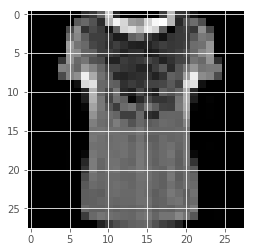

In [6]:
plt.imshow(X_train_OOD[1,:].reshape(28,28),cmap='gray')
plt.show()

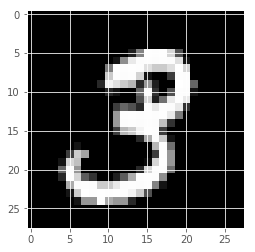

In [7]:
plt.imshow(X_train[1,:].reshape(28,28),cmap='gray')
plt.show()

In [8]:
y_train[1]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [102]:
def neural_network_test(x, W_0, b_0, W_1, b_1,W_2, b_2):
    h = tf.nn.relu(tf.matmul(x, W_0) + b_0)
    h = tf.nn.relu(tf.matmul(h, W_1) + b_1)
    h = (tf.matmul(h, W_2) + b_2)
    y = tf.nn.softmax(h)
    return y

M =1
D = 28*28
D2 = 10
n_intergal_sample = 10
sigma0=.3
h1 = 300
h2 = 50

tf.reset_default_graph()
Y = tf.placeholder(tf.float32, [None,D2], name='Y')
X = tf.placeholder(tf.float32, [None,D], name='X')


mu_w0 = tf.get_variable("w0_mu",[D,h1])
mu_b0 = tf.get_variable("b0_mu",[1,h1])
mu_w1 = tf.get_variable("w1_mu",[h1,h2])
mu_b1 = tf.get_variable("b1_mu",[1,h2])
mu_w2 = tf.get_variable("w2_mu",[h2,D2])
mu_b2 = tf.get_variable("b2_mu",[1,D2])

r_w0 = tf.get_variable("w0_sigma",[D,h1])
r_b0 = tf.get_variable("b0_sigma",[1,h1])
r_w1 = tf.get_variable("w1_sigma",[h1,h2])
r_b1 = tf.get_variable("b1_sigma",[1,h2])
r_w2 = tf.get_variable("w2_sigma",[h2,D2])
r_b2 = tf.get_variable("b2_sigma",[1,D2])

sigma_w0 = r_w0**2
sigma_b0 = r_b0**2
sigma_w1 = r_w1**2
sigma_b1 = r_b1**2
sigma_w2 = r_w2**2
sigma_b2 = r_b2**2

"""
sigma_w0 = tf.log(1+tf.exp(r_w0))
sigma_b0 = tf.log(1+tf.exp(r_b0))
sigma_w1 = tf.log(1+tf.exp(r_w1))
sigma_b1 = tf.log(1+tf.exp(r_b1))
"""

y_model = neural_network_test(X,mu_w0,mu_b0,mu_w1,mu_b1,mu_w2,mu_b2)
likelihood = tf.tensordot(y_model[0],Y[0],1)
cross_ent = tf.reduce_mean(-tf.reduce_sum(Y*tf.log(y_model), reduction_indices=[1]))


correct_pred = tf.equal(tf.argmax(y_model,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

#entropy(y_model)


p=0
for i in range(M):
    xi = tf.reshape(X[i],[1,D])
    yi = tf.reshape(Y[i],[1,D2])
    xis = tf.stack([xi]*n_intergal_sample)
    yis = tf.stack([yi]*n_intergal_sample)

    mu_w0s = tf.stack([mu_w0]*n_intergal_sample)
    mu_b0s = tf.stack([mu_b0]*n_intergal_sample)
    mu_w1s = tf.stack([mu_w1]*n_intergal_sample)
    mu_b1s = tf.stack([mu_b1]*n_intergal_sample)
    mu_w2s = tf.stack([mu_w2]*n_intergal_sample)
    mu_b2s = tf.stack([mu_b2]*n_intergal_sample)
    
    sigma_w0s = tf.stack([sigma_w0]*n_intergal_sample)
    sigma_b0s = tf.stack([sigma_b0]*n_intergal_sample)
    sigma_w1s = tf.stack([sigma_w1]*n_intergal_sample)
    sigma_b1s = tf.stack([sigma_b1]*n_intergal_sample)
    sigma_w2s = tf.stack([sigma_w2]*n_intergal_sample)
    sigma_b2s = tf.stack([sigma_b2]*n_intergal_sample)
    
       
    eps1 = tf.random_normal(shape=[n_intergal_sample,D,h1], mean=0.0, stddev=1,dtype=tf.float32)
    eps2 = tf.random_normal(shape=[n_intergal_sample,1,h1], mean=0.0, stddev=1,dtype=tf.float32)
    eps3 = tf.random_normal(shape=[n_intergal_sample,h1,h2], mean=0.0, stddev=1,dtype=tf.float32)
    eps4 = tf.random_normal(shape=[n_intergal_sample,1,h2], mean=0.0, stddev=1,dtype=tf.float32)
    eps5 = tf.random_normal(shape=[n_intergal_sample,h2,D2], mean=0.0, stddev=1,dtype=tf.float32)
    eps6 = tf.random_normal(shape=[n_intergal_sample,1,D2], mean=0.0, stddev=1,dtype=tf.float32)
    
    w0 = mu_w0s + sigma_w0s * eps1
    b0 = mu_b0s + sigma_b0s * eps2
    w1 = mu_w1s + sigma_w1s * eps3
    b1 = mu_b1s + sigma_b1s * eps4
    w2 = mu_w2s + sigma_w2s * eps5
    b2 = mu_b2s + sigma_b2s * eps6

    y_models = neural_network_test(xis,w0,b0,w1,b1,w2,b2)
    pis = tf.reduce_sum(tf.multiply(y_models,yis), 1)
    
    cross_ents = tf.reduce_mean(-tf.reduce_sum(yis*tf.log(y_models), reduction_indices=[1]))
    
    pi = tf.reduce_mean(pis)
    p = p + tf.log(pi)

train_step = tf.train.GradientDescentOptimizer(0.001).minimize(-p)
train_step1 = tf.train.GradientDescentOptimizer(0.005).minimize(cross_ent)
#train_step1 = tf.train.GradientDescentOptimizer(0.05).minimize(-likelihood)

with tf.Session() as sess:
    start_time = time.time()
    
    lm_w0=[]
    ls_w0=[]
    lm_b0=[]
    ls_b0=[]
    
    lm_w1=[]
    ls_w1=[]
    lm_b1=[]
    ls_b1=[]
    
    lm_w2=[]
    ls_w2=[]
    lm_b2=[]
    ls_b2=[]
    
    sess.run(tf.global_variables_initializer())

    for i in range(100000):
        #seed = np.random.randint(0,n,M)
        #print x[seed]
        #x_batch = x[seed].reshape((M,1))
        #y_batch = y[seed].reshape((M,1))
        batch = mnist.train.next_batch(M)
        x_batch = batch[0]
        y_batch = batch[1]
        if i%1000==0:
            mu1 = sess.run(mu_w0,{X: x_batch, Y: y_batch})
            sigma1 = sess.run(sigma_w0,{X: x_batch, Y: y_batch})
            mu2 = sess.run(mu_b0,{X: x_batch, Y: y_batch})
            sigma2 = sess.run(sigma_b0,{X: x_batch, Y: y_batch})

            mu3 = sess.run(mu_w1,{X: x_batch, Y: y_batch})
            sigma3 = sess.run(sigma_w1,{X: x_batch, Y: y_batch})
            mu4 = sess.run(mu_b1,{X: x_batch, Y: y_batch})
            sigma4 = sess.run(sigma_b1,{X: x_batch, Y: y_batch})

            mu5 = sess.run(mu_w2,{X: x_batch, Y: y_batch})
            sigma5 = sess.run(sigma_w2,{X: x_batch, Y: y_batch})
            mu6 = sess.run(mu_b2,{X: x_batch, Y: y_batch})
            sigma6 = sess.run(sigma_b2,{X: x_batch, Y: y_batch})

            #r = sess.run(p,{X: x_batch, Y: y_batch})
            #v = sess.run(var*2,{X: x_batch, Y: y_batch})

            accu = sess.run(accuracy,{X: x_batch, Y: y_batch})
            test_error = sess.run(accuracy, {X:mnist.test.images, Y:mnist.test.labels})
            soft = sess.run(likelihood,{X: x_batch, Y: y_batch})

            lm_w0.append(mu1)
            ls_w0.append(sigma1)
            lm_b0.append(mu2)
            ls_b0.append(sigma2)
            lm_w1.append(mu3)
            ls_w1.append(sigma3)
            lm_b1.append(mu4)
            ls_b1.append(sigma4)
            lm_w2.append(mu5)
            ls_w2.append(sigma5)
            lm_b2.append(mu6)
            ls_b2.append(sigma6)
            print "time:",i, time.time() - start_time, "train accuracy", accu, "test accuracy", test_error, soft
            #myplot()
            #myplot1()
        
        if i < 1000:
            sess.run(train_step,{X: x_batch, Y: y_batch})
        else:
            sess.run(train_step,{X: x_batch, Y: y_batch})
            #sess.run(train_step1,{X: x_batch, Y: y_batch})

        #sess.run(train_step2,{X: x_batch, Y: y_batch})
            
elapsed_time = time.time() - start_time
print("time: ")
print(elapsed_time)

time: 0 0.309341907501 train accuracy 0.0 test accuracy 0.1032 0.123381995
time: 1000 33.2180628777 train accuracy 0.0 test accuracy 0.5608 0.16092953
time: 2000 62.0105650425 train accuracy 0.0 test accuracy 0.7477 0.2168682
time: 3000 88.4125459194 train accuracy 0.0 test accuracy 0.8135 0.10049924
time: 4000 117.719063997 train accuracy 1.0 test accuracy 0.8331 0.7945353
time: 5000 148.908906937 train accuracy 1.0 test accuracy 0.8576 0.964233
time: 6000 177.619235039 train accuracy 1.0 test accuracy 0.8638 0.7280372
time: 7000 204.468651056 train accuracy 1.0 test accuracy 0.8689 0.649335
time: 8000 231.798812866 train accuracy 1.0 test accuracy 0.8816 0.46726128
time: 9000 259.427762985 train accuracy 1.0 test accuracy 0.8923 0.59959376
time: 10000 286.157338858 train accuracy 0.0 test accuracy 0.894 0.075427406
time: 11000 312.269670963 train accuracy 1.0 test accuracy 0.8887 0.7660739
time: 12000 338.131321907 train accuracy 0.0 test accuracy 0.8947 0.1827956
time: 13000 364.142

In [ ]:
def myplot():
    t = np.linspace(-10,10, 100).reshape((100,1))
    plt.plot(x,y,"d",color = "red")
    for i in range(50):

        W_0 = np.random.normal(np.mean(lm_w0[-10:],0),np.mean(ls_w0[-10:],0))
        b_0 = np.random.normal(np.mean(lm_b0[-10:],0),np.mean(ls_b0[-10:],0))
        W_1 = np.random.normal(np.mean(lm_w1[-10:],0),np.mean(ls_w1[-10:],0))
        b_1 = np.random.normal(np.mean(lm_b1[-10:],0),np.mean(ls_b1[-10:],0))
        W_2 = np.random.normal(np.mean(lm_w2[-10:],0),np.mean(ls_w2[-10:],0))
        b_2 = np.random.normal(np.mean(lm_b2[-10:],0),np.mean(ls_b2[-10:],0))

        #yy = neural_network_test1(t, W_0, b_0, W_1, b_1, W_2, b_2) + np.random.normal(0,.2)
        yy = np.random.normal(neural_network_test1(t, W_0, b_0, W_1, b_1, W_2, b_2),.2)
        plt.plot(t,yy,0.0001)
        plt.plot(x,y,"d",color = "red")
    plt.show()
myplot()

In [93]:
def neural_network_test(x, W_0, b_0, W_1, b_1,W_2, b_2):
    h = tf.nn.relu(tf.matmul(x, W_0) + b_0)
    h = tf.nn.relu(tf.matmul(h, W_1) + b_1)
    h = (tf.matmul(h, W_2) + b_2)
    y = tf.nn.softmax(h)
    return y

M =10
D = 28*28
D2 = 10
n_intergal_sample = 5
h1 = 300
h2 = 50

tf.reset_default_graph()
Y = tf.placeholder(tf.float32, [None,D2], name='Y')
X = tf.placeholder(tf.float32, [None,D], name='X')


mu_w0 = tf.get_variable("w0_mu",[D,h1])
mu_b0 = tf.get_variable("b0_mu",[1,h1])
mu_w1 = tf.get_variable("w1_mu",[h1,h2])
mu_b1 = tf.get_variable("b1_mu",[1,h2])
mu_w2 = tf.get_variable("w2_mu",[h2,D2])
mu_b2 = tf.get_variable("b2_mu",[1,D2])

r_w0 = tf.get_variable("w0_sigma",[D,h1])
r_b0 = tf.get_variable("b0_sigma",[1,h1])
r_w1 = tf.get_variable("w1_sigma",[h1,h2])
r_b1 = tf.get_variable("b1_sigma",[1,h2])
r_w2 = tf.get_variable("w2_sigma",[h2,D2])
r_b2 = tf.get_variable("b2_sigma",[1,D2])

sigma_w0 = r_w0**2
sigma_b0 = r_b0**2
sigma_w1 = r_w1**2
sigma_b1 = r_b1**2
sigma_w2 = r_w2**2
sigma_b2 = r_b2**2

"""
sigma_w0 = tf.log(1+tf.exp(r_w0))
sigma_b0 = tf.log(1+tf.exp(r_b0))
sigma_w1 = tf.log(1+tf.exp(r_w1))
sigma_b1 = tf.log(1+tf.exp(r_b1))
"""

py_model = neural_network_test(X,mu_w0,mu_b0,mu_w1,mu_b1,mu_w2,mu_b2)
likelihood = tf.tensordot(py_model[0],Y[0],1)
cross_ent = tf.reduce_mean(-tf.reduce_sum(Y*tf.log(py_model), reduction_indices=[1]))

pent = -tf.reduce_sum(py_model*tf.log(py_model), reduction_indices=[1])

psure = pent<0.8
pcorrect_pred = tf.equal(tf.argmax(py_model,1), tf.argmax(Y,1))

pcorrect_pred1 = tf.cast(pcorrect_pred, tf.float32)
psure1 = tf.cast(psure, tf.float32)

pcorrect_pred_for_sure = tf.add(1 - psure1, pcorrect_pred1) >= 1

paccuracy = tf.reduce_mean(tf.cast(pcorrect_pred, tf.float32))
paccuracy_for_sure = tf.reduce_mean(tf.cast(pcorrect_pred_for_sure, tf.float32))
sure_percent = tf.reduce_mean(psure1)

test1 = psure
test2 = psure1
test3 = 1 - psure1

p=0
c=0
ac = 0
ac_for_sure = 0
for i in range(M):
    xi = tf.reshape(X[i],[1,D])
    yi = tf.reshape(Y[i],[1,D2])
    xis = tf.stack([xi]*n_intergal_sample)
    yis = tf.stack([yi]*n_intergal_sample)

    mu_w0s = tf.stack([mu_w0]*n_intergal_sample)
    mu_b0s = tf.stack([mu_b0]*n_intergal_sample)
    mu_w1s = tf.stack([mu_w1]*n_intergal_sample)
    mu_b1s = tf.stack([mu_b1]*n_intergal_sample)
    mu_w2s = tf.stack([mu_w2]*n_intergal_sample)
    mu_b2s = tf.stack([mu_b2]*n_intergal_sample)
    
    sigma_w0s = tf.stack([sigma_w0]*n_intergal_sample)
    sigma_b0s = tf.stack([sigma_b0]*n_intergal_sample)
    sigma_w1s = tf.stack([sigma_w1]*n_intergal_sample)
    sigma_b1s = tf.stack([sigma_b1]*n_intergal_sample)
    sigma_w2s = tf.stack([sigma_w2]*n_intergal_sample)
    sigma_b2s = tf.stack([sigma_b2]*n_intergal_sample)
    
       
    eps1 = tf.random_normal(shape=[n_intergal_sample,D,h1], mean=0.0, stddev=1,dtype=tf.float32)
    eps2 = tf.random_normal(shape=[n_intergal_sample,1,h1], mean=0.0, stddev=1,dtype=tf.float32)
    eps3 = tf.random_normal(shape=[n_intergal_sample,h1,h2], mean=0.0, stddev=1,dtype=tf.float32)
    eps4 = tf.random_normal(shape=[n_intergal_sample,1,h2], mean=0.0, stddev=1,dtype=tf.float32)
    eps5 = tf.random_normal(shape=[n_intergal_sample,h2,D2], mean=0.0, stddev=1,dtype=tf.float32)
    eps6 = tf.random_normal(shape=[n_intergal_sample,1,D2], mean=0.0, stddev=1,dtype=tf.float32)
    
    w0 = mu_w0s + sigma_w0s * eps1
    b0 = mu_b0s + sigma_b0s * eps2
    w1 = mu_w1s + sigma_w1s * eps3
    b1 = mu_b1s + sigma_b1s * eps4
    w2 = mu_w2s + sigma_w2s * eps5
    b2 = mu_b2s + sigma_b2s * eps6

    y_models = neural_network_test(xis,w0,b0,w1,b1,w2,b2)
    
    pis = tf.reduce_sum(tf.multiply(y_models,yis), [1,2])
    """
    #cross_ents = tf.reduce_mean(-tf.reduce_sum(yis*tf.log(y_models), reduction_indices=[1]))
    y_model = tf.reduce_mean(y_models,0)
    ent = -tf.reduce_sum(y_model*tf.log(y_model), reduction_indices=[1])

    sure = ent>0.5
    sure1 = tf.cast(sure, tf.float32)
    correct_pred = tf.cast(tf.equal(tf.argmax(y_model,1), tf.argmax(Y[i],1)), tf.float32)

    correct_pred_for_sure = tf.add(sure1, correct_pred) >= 1
    correct_pred_for_sure = tf.cast(correct_pred_for_sure,tf.float32)
    
    ac+=correct_pred
    ac_for_sure+=correct_pred_for_sure
    """
    pi = tf.reduce_mean(pis)
    #cross_ent1 = tf.reduce_mean(cross_ents)
    #c = c + cross_ent1
    p = p + tf.log(pi)
    
#accuracy = ac/M
#accuracy_for_sure = ac_for_sure/M

train_step = tf.train.GradientDescentOptimizer(0.001).minimize(-p)
train_step1 = tf.train.GradientDescentOptimizer(0.005).minimize(cross_ent)
#train_step1 = tf.train.GradientDescentOptimizer(0.05).minimize(-likelihood)

with tf.Session() as sess:
    start_time = time.time()
    
    lm_w0=[]
    ls_w0=[]
    lm_b0=[]
    ls_b0=[]
    
    lm_w1=[]
    ls_w1=[]
    lm_b1=[]
    ls_b1=[]
    
    lm_w2=[]
    ls_w2=[]
    lm_b2=[]
    ls_b2=[]
    
    sess.run(tf.global_variables_initializer())

    for i in range(100000):
        #seed = np.random.randint(0,n,M)
        #print x[seed]
        #x_batch = x[seed].reshape((M,1))
        #y_batch = y[seed].reshape((M,1))
        batch = mnist.train.next_batch(M)
        x_batch = batch[0]
        y_batch = batch[1]
        if i%1000==0:
            mu1 = sess.run(mu_w0,{X: x_batch, Y: y_batch})
            sigma1 = sess.run(sigma_w0,{X: x_batch, Y: y_batch})
            mu2 = sess.run(mu_b0,{X: x_batch, Y: y_batch})
            sigma2 = sess.run(sigma_b0,{X: x_batch, Y: y_batch})

            mu3 = sess.run(mu_w1,{X: x_batch, Y: y_batch})
            sigma3 = sess.run(sigma_w1,{X: x_batch, Y: y_batch})
            mu4 = sess.run(mu_b1,{X: x_batch, Y: y_batch})
            sigma4 = sess.run(sigma_b1,{X: x_batch, Y: y_batch})

            mu5 = sess.run(mu_w2,{X: x_batch, Y: y_batch})
            sigma5 = sess.run(sigma_w2,{X: x_batch, Y: y_batch})
            mu6 = sess.run(mu_b2,{X: x_batch, Y: y_batch})
            sigma6 = sess.run(sigma_b2,{X: x_batch, Y: y_batch})

            train_error = sess.run(paccuracy,{X: x_batch, Y: y_batch})
            test_error = sess.run(paccuracy, {X:mnist.test.images, Y:mnist.test.labels})
            accu_for_sure = sess.run(paccuracy_for_sure, {X:mnist.test.images, Y:mnist.test.labels})
            t = sess.run(sure_percent, {X:mnist.test.images, Y:mnist.test.labels})
            """
            t1 = sess.run(test1, {X: x_batch, Y: y_batch})
            t2 = sess.run(test2, {X: x_batch, Y: y_batch})
            t3 = sess.run(test3, {X: x_batch, Y: y_batch})
    
            soft = sess.run(pent,{X: x_batch, Y: y_batch})
            soft1 = sess.run(psure,{X: x_batch, Y: y_batch})
            soft2 = sess.run(pcorrect_pred_for_sure,{X: x_batch, Y: y_batch})
            """
            lm_w0.append(mu1)
            ls_w0.append(sigma1)
            lm_b0.append(mu2)
            ls_b0.append(sigma2)
            lm_w1.append(mu3)
            ls_w1.append(sigma3)
            lm_b1.append(mu4)
            ls_b1.append(sigma4)
            lm_w2.append(mu5)
            ls_w2.append(sigma5)
            lm_b2.append(mu6)
            ls_b2.append(sigma6)
            print "time:",i, time.time() - start_time, "train accuracy", train_error, "test accuracy", test_error,"accuracy for sure",accu_for_sure
            print t
            """
            print t1
            print t2
            print t3
            print soft
            print soft1
            print soft2
            """
        if i < 1000:
            sess.run(train_step1,{X: x_batch, Y: y_batch})
        else:
            sess.run(train_step1,{X: x_batch, Y: y_batch})
            #sess.run(train_step1,{X: x_batch, Y: y_batch})

        #sess.run(train_step2,{X: x_batch, Y: y_batch})
            
elapsed_time = time.time() - start_time
print("time: ")
print(elapsed_time)

time: 0 0.894484996796 train accuracy 0.0 test accuracy 0.1084 accuracy for sure 1.0
0.0
time: 1000 2.16865205765 train accuracy 0.9 test accuracy 0.8513 accuracy for sure 0.9957
0.4332
time: 2000 3.40011191368 train accuracy 1.0 test accuracy 0.8897 accuracy for sure 0.9852
0.684
time: 3000 4.63715600967 train accuracy 0.9 test accuracy 0.903 accuracy for sure 0.9794
0.7763
time: 4000 5.95673203468 train accuracy 0.9 test accuracy 0.9138 accuracy for sure 0.9787
0.8252
time: 5000 7.21977591515 train accuracy 0.8 test accuracy 0.9203 accuracy for sure 0.9776
0.8414
time: 6000 8.65268993378 train accuracy 0.9 test accuracy 0.9263 accuracy for sure 0.9789
0.8539
time: 7000 9.93330907822 train accuracy 1.0 test accuracy 0.9287 accuracy for sure 0.9795
0.8645
time: 8000 11.2016429901 train accuracy 0.8 test accuracy 0.931 accuracy for sure 0.9772
0.8759
time: 9000 12.7750580311 train accuracy 0.8 test accuracy 0.9314 accuracy for sure 0.9759
0.8854
time: 10000 14.3801438808 train accuracy 

time: 85000 114.585763931 train accuracy 1.0 test accuracy 0.9772 accuracy for sure 0.9855
0.9817
time: 86000 115.849957943 train accuracy 1.0 test accuracy 0.9767 accuracy for sure 0.9857
0.9804
time: 87000 117.125354052 train accuracy 1.0 test accuracy 0.9773 accuracy for sure 0.9865
0.9808
time: 88000 118.480700016 train accuracy 1.0 test accuracy 0.9775 accuracy for sure 0.9851
0.9829
time: 89000 119.778303862 train accuracy 1.0 test accuracy 0.9774 accuracy for sure 0.986
0.9823
time: 90000 121.044502974 train accuracy 1.0 test accuracy 0.976 accuracy for sure 0.9846
0.9815
time: 91000 122.300796032 train accuracy 1.0 test accuracy 0.9764 accuracy for sure 0.9851
0.9828
time: 92000 123.565042973 train accuracy 1.0 test accuracy 0.9788 accuracy for sure 0.9859
0.9827
time: 93000 124.840938091 train accuracy 1.0 test accuracy 0.9776 accuracy for sure 0.9856
0.9829
time: 94000 126.256118059 train accuracy 1.0 test accuracy 0.9788 accuracy for sure 0.9866
0.9834
time: 95000 127.625298

In [13]:
a = [[1,2,3],[3,4,5]]
b = [[7,8,9,2],[10,11,12,2]]
np.concatenate([a,b],1)

array([[ 1,  2,  3,  7,  8,  9,  2],
       [ 3,  4,  5, 10, 11, 12,  2]])

INFO:tensorflow:Restoring parameters from ./classification_mnist/model.ckpt
time: 0 0.7875990867614746
-0.029235635
train: 1.0 test: 0.9683
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
[[0.00208949 0.01587804 0.00402303 0.01130913 0.09880812 0.00921612
  0.00326218 0.24517821 0.00859935 0.6016361 ]]


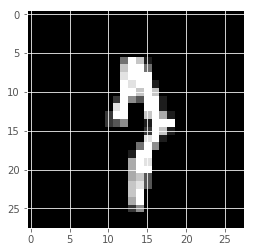

[[0.00193289 0.0208991  0.00458472 0.01593112 0.08598191 0.01317981
  0.0032603  0.2719804  0.01097124 0.5712787 ]]
0.2382615
[[0.00098996 0.01149268 0.0023723  0.00847405 0.07001519 0.00698961
  0.00165345 0.26094025 0.00575817 0.63131446]]
0.28605235
[[0.00189308 0.01824709 0.00426055 0.01212468 0.09025138 0.01043722
  0.00312124 0.22344406 0.00862127 0.62759936]]
0.2677824
[[0.00107088 0.01099041 0.00245138 0.0082609  0.06622978 0.0069561
  0.00169366 0.34826833 0.00566794 0.54841053]]
0.28376535
[[0.00101174 0.01439749 0.00265998 0.00952329 0.06003464 0.0076363
  0.0017722  0.3404125  0.00646073 0.55609107]]
0.30694312
[[0.00163805 0.01647941 0.00362288 0.01060676 0.07276546 0.00893549
  0.00270326 0.37203404 0.00783712 0.50337785]]
0.33739883
[[0.00114768 0.01830558 0.00348629 0.01275064 0.06105387 0.0104571
  0.00212636 0.37779027 0.00871377 0.50416845]]
0.37945405
[[0.00062834 0.01257654 0.00190835 0.00876307 0.07153171 0.00654465
  0.00118539 0.39533097 0.00558366 0.49594748]]


[[0.00156772 0.01693441 0.0041024  0.01174963 0.02375599 0.00846473
  0.00248749 0.78727496 0.00745265 0.13620992]]
0.79700905
[[0.00147791 0.01340881 0.00327005 0.00987588 0.01976285 0.00668828
  0.00216332 0.7858217  0.00610778 0.1514234 ]]
0.8115776
[[6.7567045e-04 1.2678938e-02 2.2018617e-03 1.0576909e-02 1.9259913e-02
  6.4008827e-03 1.1902159e-03 7.7935195e-01 5.5610747e-03 1.6210245e-01]]
0.77273047
[[0.00177829 0.01636506 0.00425667 0.01237424 0.02178542 0.00885729
  0.00258682 0.785781   0.00775141 0.13846396]]
0.7979846
[[0.00186815 0.01646064 0.00386352 0.01191029 0.02282985 0.00777946
  0.00266418 0.7834816  0.00746367 0.14167887]]
0.7954834
[[0.00187272 0.0172918  0.00442523 0.01245138 0.02545339 0.00889108
  0.00287213 0.77823496 0.008097   0.14041047]]
0.78405595
[[6.8291108e-04 1.1397282e-02 2.0755250e-03 7.4078371e-03 1.8254833e-02
  5.0195171e-03 1.1684571e-03 8.4675562e-01 4.3011922e-03 1.0293702e-01]]
0.79403776
[[0.00143465 0.01473464 0.0034761  0.0113145  0.021345

In [ ]:
def neural_network_test(x, W_0, b_0, W_1, b_1,W_2, b_2):
    h = tf.nn.relu(tf.matmul(x, W_0) + b_0)
    h = tf.nn.relu(tf.matmul(h, W_1) + b_1)
    h = (tf.matmul(h, W_2) + b_2)
    y = tf.nn.softmax(h)
    return y

M = 1
D = 28*28
D2 = 10
n_intergal_sample = 200
h1 = 300
h2 = 50

tf.reset_default_graph()
Y = tf.placeholder(tf.float32, [None,D2], name='Y')
X = tf.placeholder(tf.float32, [None,D], name='X')


mu_w0 = tf.get_variable("w0_mu",[D,h1])
mu_b0 = tf.get_variable("b0_mu",[1,h1])
mu_w1 = tf.get_variable("w1_mu",[h1,h2])
mu_b1 = tf.get_variable("b1_mu",[1,h2])
mu_w2 = tf.get_variable("w2_mu",[h2,D2])
mu_b2 = tf.get_variable("b2_mu",[1,D2])

r_w0 = tf.get_variable("w0_sigma",[D,h1])
r_b0 = tf.get_variable("b0_sigma",[1,h1])
r_w1 = tf.get_variable("w1_sigma",[h1,h2])
r_b1 = tf.get_variable("b1_sigma",[1,h2])
r_w2 = tf.get_variable("w2_sigma",[h2,D2])
r_b2 = tf.get_variable("b2_sigma",[1,D2])

sigma_w0 = r_w0**2
sigma_b0 = r_b0**2
sigma_w1 = r_w1**2
sigma_b1 = r_b1**2
sigma_w2 = r_w2**2
sigma_b2 = r_b2**2


py_model = neural_network_test(X,mu_w0,mu_b0,mu_w1,mu_b1,mu_w2,mu_b2)
likelihood = tf.tensordot(py_model[0],Y[0],1)
cross_ent = tf.reduce_mean(-tf.reduce_sum(Y*tf.log(py_model), reduction_indices=[1]))

pent = -tf.reduce_sum(py_model*tf.log(py_model), reduction_indices=[1])
psure = pent<0.1
pcorrect_pred = tf.equal(tf.argmax(py_model,1), tf.argmax(Y,1))

pcorrect_pred1 = tf.cast(pcorrect_pred, tf.float32)
psure1 = tf.cast(psure, tf.float32)

pcorrect_pred_for_sure = tf.add(1 - psure1, pcorrect_pred1) >= 1

paccuracy = tf.reduce_mean(tf.cast(pcorrect_pred, tf.float32))
paccuracy_for_sure = tf.reduce_mean(tf.cast(pcorrect_pred_for_sure, tf.float32))
psure_percent = tf.reduce_mean(psure1)

test1 = psure
test2 = psure1
test3 = 1 - psure1

p=0
c=0
ac = 0
ac_for_sure = 0

for i in range(M):
    xi = tf.reshape(X,[M,D])
    yi = tf.reshape(Y,[M,D2])
    xis = tf.stack([xi]*n_intergal_sample)
    yis = tf.stack([yi]*n_intergal_sample)
    
    """
    mu_w0s = tf.stack([mu_w0]*n_intergal_sample)
    mu_b0s = tf.stack([mu_b0]*n_intergal_sample)
    mu_w1s = tf.stack([mu_w1]*n_intergal_sample)
    mu_b1s = tf.stack([mu_b1]*n_intergal_sample)
    mu_w2s = tf.stack([mu_w2]*n_intergal_sample)
    mu_b2s = tf.stack([mu_b2]*n_intergal_sample)
    
    sigma_w0s = tf.stack([sigma_w0]*n_intergal_sample)
    sigma_b0s = tf.stack([sigma_b0]*n_intergal_sample)
    sigma_w1s = tf.stack([sigma_w1]*n_intergal_sample)
    sigma_b1s = tf.stack([sigma_b1]*n_intergal_sample)
    sigma_w2s = tf.stack([sigma_w2]*n_intergal_sample)
    sigma_b2s = tf.stack([sigma_b2]*n_intergal_sample)
    """
       
    eps1 = tf.random_normal(shape=[n_intergal_sample,D,h1], mean=0.0, stddev=1,dtype=tf.float32)
    eps2 = tf.random_normal(shape=[n_intergal_sample,1,h1], mean=0.0, stddev=1,dtype=tf.float32)
    eps3 = tf.random_normal(shape=[n_intergal_sample,h1,h2], mean=0.0, stddev=1,dtype=tf.float32)
    eps4 = tf.random_normal(shape=[n_intergal_sample,1,h2], mean=0.0, stddev=1,dtype=tf.float32)
    eps5 = tf.random_normal(shape=[n_intergal_sample,h2,D2], mean=0.0, stddev=1,dtype=tf.float32)
    eps6 = tf.random_normal(shape=[n_intergal_sample,1,D2], mean=0.0, stddev=1,dtype=tf.float32)
    """
    w0 = mu_w0s + sigma_w0s * eps1 
    b0 = mu_b0s + sigma_b0s * eps2
    w1 = mu_w1s + sigma_w1s * eps3
    b1 = mu_b1s + sigma_b1s * eps4
    w2 = mu_w2s + sigma_w2s * eps5
    b2 = mu_b2s + sigma_b2s * eps6
    """
    w0 = mu_w0 + sigma_w0 * eps1 
    b0 = mu_b0 + sigma_b0 * eps2
    w1 = mu_w1 + sigma_w1 * eps3
    b1 = mu_b1 + sigma_b1 * eps4
    w2 = mu_w2 + sigma_w2 * eps5
    b2 = mu_b2 + sigma_b2 * eps6
    
    
    eps11 = tf.reshape(eps1,[n_intergal_sample,D*h1])
    eps22 = tf.reshape(eps2,[n_intergal_sample,1*h1])
    eps33 = tf.reshape(eps3,[n_intergal_sample,h1*h2])
    eps44 = tf.reshape(eps4,[n_intergal_sample,1*h2])
    eps55 = tf.reshape(eps5,[n_intergal_sample,h2*D2])
    eps66 = tf.reshape(eps6,[n_intergal_sample,1*D2])
    
    input_latent = tf.concat([eps11,eps22,eps33,eps44,eps55,eps66],1)
    
    hidden1 = tf.layers.dense(input_latent, 15, activation=tf.nn.relu)
    #hidden2 = tf.layers.dense(hidden1, 5, activation=tf.nn.relu)
    #hidden3 = tf.layers.dense(hidden2, 30, activation=tf.nn.relu)
    
    output = tf.layers.dense(hidden1,(D*h1 + 1*h1+ h1*h2 + 1*h2 + h2*D2 + 1*D2), activation=None)
      
    w0 = tf.reshape(output[:,0:D*h1],[n_intergal_sample,D,h1])
    b0 = tf.reshape(output[:,D*h1:D*h1+1*h1],[n_intergal_sample,1,h1])
    w1 = tf.reshape(output[:,D*h1+1*h1:D*h1+1*h1+h1*h2],[n_intergal_sample,h1,h2])
    b1 = tf.reshape(output[:,D*h1+1*h1+h1*h2:D*h1+1*h1+h1*h2+1*h2],[n_intergal_sample,1,h2])
    w2 = tf.reshape(output[:,D*h1+1*h1+h1*h2+1*h2:D*h1+1*h1+h1*h2+1*h2+h2*D2],[n_intergal_sample,h2,D2])
    b2 = tf.reshape(output[:,D*h1+1*h1+h1*h2+1*h2+h2*D2:D*h1+1*h1+h1*h2+1*h2+h2*D2+1*D2],[n_intergal_sample,1,D2])
    
    y_models = neural_network_test(xis,w0,b0,w1,b1,w2,b2)
    
    XX = tf.reshape([X]*n_intergal_sample,[n_intergal_sample,M,D])
    pred = tf.reduce_mean(neural_network_test(XX,w0,b0,w1,b1,w2,b2),0)
    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(Y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
    XX_test = tf.reshape([X]*n_intergal_sample,[n_intergal_sample,10000,D])
    pred_test = tf.reduce_mean(neural_network_test(XX_test,w0,b0,w1,b1,w2,b2),0)
    correct_pred_test = tf.equal(tf.argmax(pred_test,1), tf.argmax(Y,1))
    accuracy_test = tf.reduce_mean(tf.cast(correct_pred_test, tf.float32))
    
    XX_t1 = tf.reshape([X]*n_intergal_sample,[n_intergal_sample,M,D])
    raw = neural_network_test(XX_t1,w0,b0,w1,b1,w2,b2)
    pred_t1 = tf.reduce_mean(raw,0)
    entropy = -tf.reduce_sum(pred_t1*tf.log(pred_t1), reduction_indices=[1])
    
    correct_pred_t1 = tf.equal(tf.argmax(pred_t1,1), tf.argmax(Y,1))
    accuracy_t1 = tf.reduce_mean(tf.cast(correct_pred_t1, tf.float32))
    
    
    
    pis = tf.reduce_sum(tf.multiply(y_models,yis), [1,2])

    pi = tf.reduce_mean(pis)
    #cross_ent1 = tf.reduce_mean(cross_ents)
    #c = c + cross_ent1
    p = p + tf.log(pi)
    
eva1 = evaluation(0.2,X,Y, mu_w0,mu_b0,mu_w1,mu_b1,mu_w2,mu_b2, sigma_w0,sigma_b0,sigma_w1,sigma_b1,sigma_w2,sigma_b2)
eva2 = evaluation(0.1,X,Y, mu_w0,mu_b0,mu_w1,mu_b1,mu_w2,mu_b2, sigma_w0,sigma_b0,sigma_w1,sigma_b1,sigma_w2,sigma_b2)
eva3 = evaluation(0.05,X,Y, mu_w0,mu_b0,mu_w1,mu_b1,mu_w2,mu_b2, sigma_w0,sigma_b0,sigma_w1,sigma_b1,sigma_w2,sigma_b2)


#accuracy = ac/M
#accuracy_for_sure = ac_for_sure/M

train_step = tf.train.GradientDescentOptimizer(0.000003).minimize(-p)
#train_step1 = tf.train.GradientDescentOptimizer(0.005).minimize(cross_ent)
#train_step1 = tf.train.GradientDescentOptimizer(0.05).minimize(-likelihood)

saver = tf.train.Saver()

with tf.Session() as sess:
    start_time = time.time()
    
    lm_w0=[]
    ls_w0=[]
    lm_b0=[]
    ls_b0=[]
    
    lm_w1=[]
    ls_w1=[]
    lm_b1=[]
    ls_b1=[]
    
    lm_w2=[]
    ls_w2=[]
    lm_b2=[]
    ls_b2=[]
    
    #sess.run(tf.global_variables_initializer())
    #save_path = saver.restore(sess, "./classification_mnist/model_small.ckpt")
    save_path = saver.restore(sess, "./classification_mnist/model.ckpt")

    for i in range(60000):
        #seed = np.random.randint(0,n,M)
        #print x[seed]
        #x_batch = x[seed].reshape((M,1))
        #y_batch = y[seed].reshape((M,1))
        batch = mnist.train.next_batch(M)
        x_batch = batch[0]
        y_batch = batch[1]

        
        rightornot = sess.run(correct_pred_t1,{X: x_batch, Y: y_batch})
        
        it=0
        if rightornot[0] == False:
            predt1= sess.run(pred_t1,{X: x_batch, Y: y_batch})
            predi= sess.run(pi,{X: x_batch, Y: y_batch})
            print (y_batch)
            print (predt1)
            plt.imshow(x_batch.reshape(28,28),cmap='gray')
            plt.show()
            
            while(predi<=0.99):
                sess.run(train_step,{X: x_batch, Y: y_batch})
                sess.run(train_step,{X: x_batch, Y: y_batch})
                it+=1
                pred= sess.run(pred_t1,{X: x_batch, Y: y_batch})
                predi= sess.run(pi,{X: x_batch, Y: y_batch})
                print (pred)
                print(predi)
                if it > 500: break

        if i%200==0:

            
            #train_error = sess.run(paccuracy,{X: x_batch, Y: y_batch})
            #test_error = sess.run(paccuracy, {X:mnist.test.images, Y:mnist.test.labels})
            #accu_for_sure = sess.run(paccuracy_for_sure, {X:mnist.test.images, Y:mnist.test.labels})
            """
            t = sess.run(psure_percent, {X:mnist.test.images, Y:mnist.test.labels})
            t1 = sess.run(eva1,{X:mnist.test.images, Y:mnist.test.labels})
            t2 = sess.run(eva2,{X:mnist.test.images, Y:mnist.test.labels})
            t3 = sess.run(eva3,{X:mnist.test.images, Y:mnist.test.labels})
                    raw1 = sess.run(raw,{X:x_test, Y:y_test})
        var = np.mean(np.std(raw1,0))
        it=0
        while(var>0.3):
            plt.imshow(x_test.reshape(28,28),cmap='gray')
            plt.show()
            sess.run(train_step,{X: x_batch, Y: y_batch})
            it+=1

            if it > 100: break
            """
           
            print ("time:",i, time.time() - start_time)
            t = sess.run(p,{X: x_batch, Y: y_batch})
            print (t)
            lv=[]
            ll=[]
            
            
                        
            """           
            for j in range(5000,6000):
                x_test = np.reshape(mnist.test.images[j],[1,D])
                y_test = np.reshape(mnist.test.labels[j],[1,D2])
                #x_test = np.reshape(X_train_OOD[j],[1,D])
                #y_test = np.reshape(y_train_OOD[j],[1,D2])
                
                #x_new = (x_test+np.reshape(mnist.test.images[j-1],[1,D]))/2
                #x_test = x_new
                #y_test1 = np.reshape(mnist.test.labels[j-1],[1,D2])
                
                
                rawt1 = sess.run(raw,{X:x_test, Y:y_test})
                vart1 = np.mean(np.std(rawt1,0))
                ent = sess.run(entropy,{X:x_test, Y:y_test})
                rightornot = sess.run(correct_pred_t1,{X:x_test, Y:y_test})

                ll.append(rightornot[0])
                lv.append(vart1)
                    
                
                predt1= sess.run(pred_t1,{X:x_test, Y:y_test})
                predt2= sess.run(pred_t1,{X:x_test, Y:y_test})
                predt3=np.mean(rawt1,0)
                
                if rightornot[0] != True:
                    print (j)
                    print ("label:",np.argmax(y_test))
                    #print ("label:",np.argmax(y_test1))

                    print ("prediction1:",predt1,rightornot)
                    print ("prediction1:",predt2,rightornot)
                    print ("prediction1:",predt3,rightornot)

                    print (ent,vart1,-np.sum(predt2*np.log(predt2)))
                    
                    
                    plt.imshow(x_test.reshape(28,28),cmap='gray')
                    plt.show()
                    
                    for pre in rawt1:
                        print (np.argmax(pre))
                        print (pre)
                    """
            train_accu = sess.run(accuracy,{X: x_batch, Y: y_batch})
            test_accu = sess.run(accuracy_test,{X:mnist.test.images, Y:mnist.test.labels})
            print ("train:", train_accu, "test:", test_accu)
            #print "time:",i, time.time() - start_time, "train accuracy", train_error, "test accuracy", test_error,"accuracy for sure",accu_for_sure
            """
            print t
            print ("new evaluation bound 0.2",t1)
            print ("new evaluation bound 0.1",t2)
            print ("new evaluation bound 0.05",t3)
            """
        if i < 100:
            sess.run(train_step,{X: x_batch, Y: y_batch})
            
        else:
            sess.run(train_step,{X: x_batch, Y: y_batch})
            sess.run(train_step,{X: x_batch, Y: y_batch})
            
        if i%100==0:
            save_path = saver.save(sess, "./classification_mnist/model.ckpt")
            #save_path = saver.save(sess, "./classification_mnist/model_small.ckpt")
            
elapsed_time = time.time() - start_time
print("time: ")
print(elapsed_time)

In [176]:
from sklearn.metrics import roc_auc_score
y_true = np.array(ll)
area=0
var=0
for tmp in range(0,100):
    y_scores = np.array(lv)<tmp*1./1000
    area1 = roc_auc_score(y_true, y_scores)
    if area1>area:
        area = area1
        var = tmp*1./1000
        print var, area
        

0.0 0.5
0.093 0.5008234413316269
0.094 0.507115439943301
0.098 0.5073607720214554
0.099 0.5090162912375155


In [144]:
y_scores = np.array(lv)>0.01
roc_auc_score(y_true, y_scores)

0.30428428952647935

In [171]:
np.shape(X_train_OOD)

(55000, 784)

In [12]:
def evaluation(bound,X,Y, mu_w0,mu_b0,mu_w1,mu_b1,mu_w2,mu_b2, sigma_w0,sigma_b0,sigma_w1,sigma_b1,sigma_w2,sigma_b2):
    #point estimation
    py_model = neural_network_test(X,mu_w0,mu_b0,mu_w1,mu_b1,mu_w2,mu_b2)
    likelihood = tf.tensordot(py_model[0],Y[0],1)
    cross_ent = tf.reduce_mean(-tf.reduce_sum(Y*tf.log(py_model), reduction_indices=[1]))

    pent = -tf.reduce_sum(py_model*tf.log(py_model), reduction_indices=[1])
    psure = pent < bound
    pcorrect_pred = tf.equal(tf.argmax(py_model,1), tf.argmax(Y,1))

    pcorrect_pred1 = tf.cast(pcorrect_pred, tf.float32)
    psure1 = tf.cast(psure, tf.float32)

    pcorrect_pred_for_sure = tf.add(1 - psure1, pcorrect_pred1) >= 1

    paccuracy = tf.reduce_mean(tf.cast(pcorrect_pred, tf.float32))
    paccuracy_for_sure = tf.reduce_mean(tf.cast(pcorrect_pred_for_sure, tf.float32))
    psure_percent = tf.reduce_mean(psure1)
    
    #density estimation
    xis = tf.stack([X]*n_intergal_sample)
    yis = tf.stack([Y]*n_intergal_sample)

    mu_w0s = tf.stack([mu_w0]*n_intergal_sample)
    mu_b0s = tf.stack([mu_b0]*n_intergal_sample)
    mu_w1s = tf.stack([mu_w1]*n_intergal_sample)
    mu_b1s = tf.stack([mu_b1]*n_intergal_sample)
    mu_w2s = tf.stack([mu_w2]*n_intergal_sample)
    mu_b2s = tf.stack([mu_b2]*n_intergal_sample)
    
    sigma_w0s = tf.stack([sigma_w0]*n_intergal_sample)
    sigma_b0s = tf.stack([sigma_b0]*n_intergal_sample)
    sigma_w1s = tf.stack([sigma_w1]*n_intergal_sample)
    sigma_b1s = tf.stack([sigma_b1]*n_intergal_sample)
    sigma_w2s = tf.stack([sigma_w2]*n_intergal_sample)
    sigma_b2s = tf.stack([sigma_b2]*n_intergal_sample)
    
       
    eps1 = tf.random_normal(shape=[n_intergal_sample,D,h1], mean=0.0, stddev=1,dtype=tf.float32)
    eps2 = tf.random_normal(shape=[n_intergal_sample,1,h1], mean=0.0, stddev=1,dtype=tf.float32)
    eps3 = tf.random_normal(shape=[n_intergal_sample,h1,h2], mean=0.0, stddev=1,dtype=tf.float32)
    eps4 = tf.random_normal(shape=[n_intergal_sample,1,h2], mean=0.0, stddev=1,dtype=tf.float32)
    eps5 = tf.random_normal(shape=[n_intergal_sample,h2,D2], mean=0.0, stddev=1,dtype=tf.float32)
    eps6 = tf.random_normal(shape=[n_intergal_sample,1,D2], mean=0.0, stddev=1,dtype=tf.float32)
    
    w0 = mu_w0s + sigma_w0s * eps1
    b0 = mu_b0s + sigma_b0s * eps2
    w1 = mu_w1s + sigma_w1s * eps3
    b1 = mu_b1s + sigma_b1s * eps4
    w2 = mu_w2s + sigma_w2s * eps5
    b2 = mu_b2s + sigma_b2s * eps6

    y_models = neural_network_test(xis,w0,b0,w1,b1,w2,b2)

    y_model_ave = tf.reduce_mean(y_models,[0])
    
    entropy = -tf.reduce_sum(y_model_ave*tf.log(y_model_ave), reduction_indices=[1])

    sure = entropy < bound
    correct_predict = tf.equal(tf.argmax(y_model_ave,1), tf.argmax(Y,1))

    correct_predict1 = tf.cast(correct_predict, tf.float32)
    sure1 = tf.cast(sure, tf.float32)

    correct_pred_for_sure = tf.add(1 - sure1, correct_predict1) >= 1

    accuracy = tf.reduce_mean(tf.cast(correct_predict, tf.float32))
    accuracy_for_sure = tf.reduce_mean(tf.cast(correct_pred_for_sure, tf.float32))
    sure_percent = tf.reduce_mean(sure1)
    return [paccuracy,paccuracy_for_sure,psure_percent,accuracy,accuracy_for_sure,sure_percent,y_model_ave[0:3],entropy]

In [41]:
len(my_X)

6179

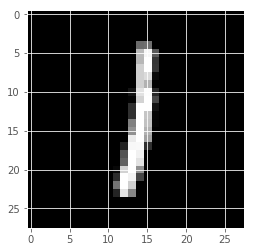

In [42]:
plt.imshow(my_X[1].reshape(28,28),cmap='gray')
plt.show()

In [79]:
my_X = []
def find_you():
    for i in range(len(mnist.train.labels)):
        if np.argmax(mnist.train.labels[i]) == 1:
            my_X.append(mnist.train.images[i])
find_you()
my_X = np.array(my_X)

In [80]:
randlabels = np.random.randint(1, len(my_X),len(my_X)/2)

In [81]:
my_Y = []
for i in range(len(my_X)):
    my_Y.append([1.,0.])
my_Y = np.array(my_Y)
for i in randlabels:
    my_Y[i] = [0.,1.]

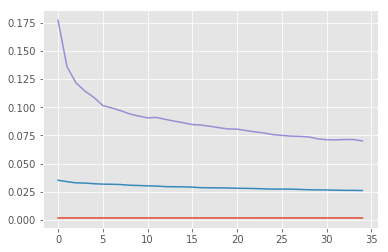

In [113]:
plt.plot(np.mean(np.mean(ls_w0,1),1))
plt.plot(np.mean(np.mean(ls_b1,1),1))
plt.plot(np.mean(np.mean(ls_b2,1),1))
plt.show()

In [112]:
np.mean(ls_w0[-1]-ls_w0[-2])

-2.9714448e-08

In [7]:
mnist.test.images

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)